#0. Env setup

In [89]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark
!pip install sseclient
!pip install bitarray mmh3

In [90]:
import datetime
import time
import json
import os

from sseclient import SSEClient as EventSource
from tqdm import tqdm

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mmh3

from bitarray import bitarray

In [92]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import BooleanType, IntegerType, StringType, StructField, StructType
from pyspark.sql.functions import udf, col

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#1. Sample from the Stream

In [93]:
# Wikimedia Stream URL
STREAM_URL = 'https://stream.wikimedia.org/v2/stream/recentchange'
WIKI = 'enwiki'  # Client-side filter

# Configuration
SAMPLE_RATE = 0.2  # Keep 20% of records

In [104]:
def is_sampled(record_id, sample_rate=SAMPLE_RATE):
    return hash(record_id) % 100 < sample_rate * 100


def get_url(base_url, since):
    return base_url + '?since=' + str(int(time.mktime(since.timetuple())))


def sample_data(url, output_folder, num_records, chunk_size, wiki=WIKI, sample_rate=SAMPLE_RATE):
    os.makedirs(output_folder, exist_ok=True)

    # Data collection
    sampled_records = []

    # Initialize tqdm progress bar
    with tqdm(total=num_records, desc="Processing Records", dynamic_ncols=True) as progress_bar:
        # Process events from the stream
        for event in EventSource(url):
            if progress_bar.n >= num_records:  # Ensure we don't exceed the required number of records
                break

            try:
                change = json.loads(event.data)
                # Filter for specific wiki and type
                if change.get("wiki") == wiki and change.get('type') == 'edit':
                    record_id = change.get("id")
                    if is_sampled(record_id, sample_rate):  # Apply hash-based sampling
                        sampled_records.append({
                            "id": record_id,
                            "title": change.get("title"),
                            "timestamp": change.get("timestamp"),
                            "user": change.get("user"),
                            "bot": change.get("bot"),
                            "minor": change.get("minor"),
                            "change": change.get("length", {}).get("new", 0) - change.get("length", {}).get("old", 0),
                            "comment": change.get("comment"),
                        })
                        progress_bar.update(1)  # Update the progress bar

                        # Write to CSV every chunk_size records
                        if len(sampled_records) >= chunk_size:
                            output_file = os.path.join(output_folder,
                                                       f"sampled_data_{progress_bar.n // chunk_size}.csv")
                            pd.DataFrame(sampled_records).to_csv(output_file, index=False)
                            sampled_records = []  # Clear the buffer

            except json.JSONDecodeError:
                continue

        # Write any remaining records
        if sampled_records:
            output_file = os.path.join(output_folder, f"sampled_data_{(progress_bar.n // chunk_size) + 1}.csv")
            pd.DataFrame(sampled_records).to_csv(output_file, index=False)

Sample 40K of records (with 20% sampling) to use it as a training dataset for classifier

In [105]:
sample_data(
    url=get_url(STREAM_URL, since=datetime.datetime(2024, 11, 10, 00, 00)),
    output_folder='../data/training_data',
    num_records=40000,
    chunk_size=10000
)

Processing Records: 100%|██████████| 40000/40000 [14:00<00:00, 47.60it/s]


Load more data to predict labels and collect them to train the Bloom Filter later

In [152]:
sample_data(
    url=STREAM_URL,
    output_folder='../data/unlabeled_data',
    num_records=40000,
    chunk_size=10000
)

Processing Records: 100%|██████████| 40000/40000 [13:59<00:00, 47.65it/s]


# 2. Distribution of edits per human users and bots.

In [162]:
spark = SparkSession.builder.appName("ExploratoryDataAnalysis").getOrCreate()

In [163]:
data_path = "../data/training_data"

df = spark.read.csv(f"{data_path}/*.csv", header=True, inferSchema=True)
df.show()

df.printSchema()

+----------+--------------------+----------+--------------+-----+-----+------+--------------------+
|        id|               title| timestamp|          user|  bot|minor|change|             comment|
+----------+--------------------+----------+--------------+-----+-----+------+--------------------+
|1839716918|  Alexander Nicolson|1731314002|      Jevansen|False|False|     1|Moving from [[Cat...|
|1839717001|        Loud Records|1731314022|  Orlandus 426|False|False|    17|                NULL|
|1839717003|1999 J.League Div...|1731314019|GiofanniRahman|False|False|  -265|/* Foreign player...|
|1839717002| User:MolecularPilot|1731314023|MolecularPilot|False|False|    35|New Message (simu...|
|1839717004|List of awards an...|1731314019|     Jolly1253|False|False|   -84|/* Awards and nom...|
|1839717006|User:ClueBot III/...|1731314024|   ClueBot III| True|False|   620|Updating detailed...|
|1839717009|       I (2016 film)|1731314024|       Monkbot| True| True|     1|[[User:Monkbot/ta...|


## 2.1 Assuming the stream is too big to store distinct users in memory

**Assymption**: We want to estimate the number of distinct items in a data stream that is too large to fit in memory. By using this numbers inside selected time periods we will see the aproximate distribution.


1. We aim to use results as a way to draw data distribution with a given assumbtion that we cannot count it as it is.
2. We want to compare results based on probabilistic distinct users count and real distinct users count.
3. We will add HyperLogLog algorithm to comparison (from spark approx_count_distinct function).


**Step 1**:
We hash each element in the stream and track specific patterns in the hash values to estimate distinct elements.

Multiple random hash functions are created for parallel estimations.

Track the smallest hash value (minima) for each hash function.

Combine the minima from all hash functions to estimate the size of the unique set.

This approach avoids storing all user and bot data by using hashing. It sacrifices exact counts for efficiency and scalability, which is essential with large-scale streams of data.

In [175]:
import random
from pyspark.sql.functions import from_unixtime, date_format, collect_list, col
from pyspark.sql.types import StructType, StructField, StringType, FloatType

# Hashing to Estimate the Size of a Stream
def randomHash(modulus):
    a, b = random.randint(0, modulus-1), random.randint(0, modulus-1)
    def f(x):
        return (a * x + b) % modulus
    return f

def flajolet_martin(stream, numParallelHashes=18):
    modulus = 2**20
    hashes = [randomHash(modulus) for _ in range(numParallelHashes)]
    minima = [modulus] * numParallelHashes

    for i in stream:
        hashValues = [h(hash(i)) for h in hashes]
        for j, newValue in enumerate(hashValues):
            minima[j] = min(minima[j], newValue)

    return modulus / sum(minima) * len(minima)


df = df.withColumn("formatted_timestamp", from_unixtime(col("timestamp")))
df = df.withColumn("hour", date_format(col("formatted_timestamp"), "yyyy-MM-dd HH:00:00"))
df = df.dropna(subset=["hour"])

time_grouped = df.groupBy("hour").agg(
    collect_list("user").alias("user_names"),
    collect_list("bot").alias("bot_flags")
)

def apply_flajolet_martin(row):
    user_estimate = flajolet_martin(row["user_names"])
    bot_estimate = flajolet_martin([name for name, is_bot in zip(row["user_names"], row["bot_flags"]) if is_bot == 'True'])
    return (row["hour"], float(user_estimate), float(bot_estimate))

# Resilient Distributed Dataset
time_grouped_rdd = time_grouped.rdd.map(lambda row: apply_flajolet_martin(row))

schema = StructType([
    StructField("hour", StringType(), True),
    StructField("distinct_users", FloatType(), True),
    StructField("distinct_bots", FloatType(), True),
])

final_df = spark.createDataFrame(time_grouped_rdd, schema=schema).orderBy("hour")
final_df.show()

+-------------------+--------------+-------------+
|               hour|distinct_users|distinct_bots|
+-------------------+--------------+-------------+
|2024-11-10 20:00:00|      495.5203|     7.135999|
|2024-11-10 21:00:00|     1021.7273|     29.07569|
|2024-11-10 22:00:00|      541.3247|    22.651453|
|2024-11-10 23:00:00|      637.6045|     16.67817|
|2024-11-11 00:00:00|     683.65576|    39.442722|
|2024-11-11 01:00:00|      526.7756|     21.84129|
|2024-11-11 02:00:00|      661.9798|     91.62937|
|2024-11-11 03:00:00|     548.67346|     14.02868|
|2024-11-11 04:00:00|     401.54813|     39.38207|
|2024-11-11 05:00:00|     450.39774|    26.234951|
|2024-11-11 06:00:00|     537.89984|    17.834003|
|2024-11-11 07:00:00|     542.02423|    35.305855|
|2024-11-11 08:00:00|     615.20105|    31.337467|
|2024-11-11 09:00:00|     489.21408|    24.426926|
|2024-11-11 10:00:00|     566.71277|     26.52705|
|2024-11-11 11:00:00|    1011.21716|    26.946753|
|2024-11-11 12:00:00|     458.9

**Step 2**:

Calculate real counts of human users and bots.

In [176]:
from pyspark.sql.functions import countDistinct, when

real_counts_df = df.groupBy("hour").agg(
    countDistinct(col("user")).alias("real_distinct_users"),
    countDistinct(when(col("bot") == 'True', col("user"))).alias("real_distinct_bots")
)


real_counts_df = real_counts_df.withColumn("hour", F.to_timestamp("hour"))
real_counts_df = real_counts_df.orderBy("hour")

real_counts_df.show()

+-------------------+-------------------+------------------+
|               hour|real_distinct_users|real_distinct_bots|
+-------------------+-------------------+------------------+
|2024-11-10 20:00:00|                353|                 7|
|2024-11-10 21:00:00|                838|                19|
|2024-11-10 22:00:00|                760|                22|
|2024-11-10 23:00:00|                702|                17|
|2024-11-11 00:00:00|                653|                32|
|2024-11-11 01:00:00|                607|                25|
|2024-11-11 02:00:00|                594|                31|
|2024-11-11 03:00:00|                626|                18|
|2024-11-11 04:00:00|                554|                20|
|2024-11-11 05:00:00|                540|                28|
|2024-11-11 06:00:00|                506|                18|
|2024-11-11 07:00:00|                501|                28|
|2024-11-11 08:00:00|                454|                19|
|2024-11-11 09:00:00|   

**Step 3**:

Combine estimated and real counts in order to see the distributuions.

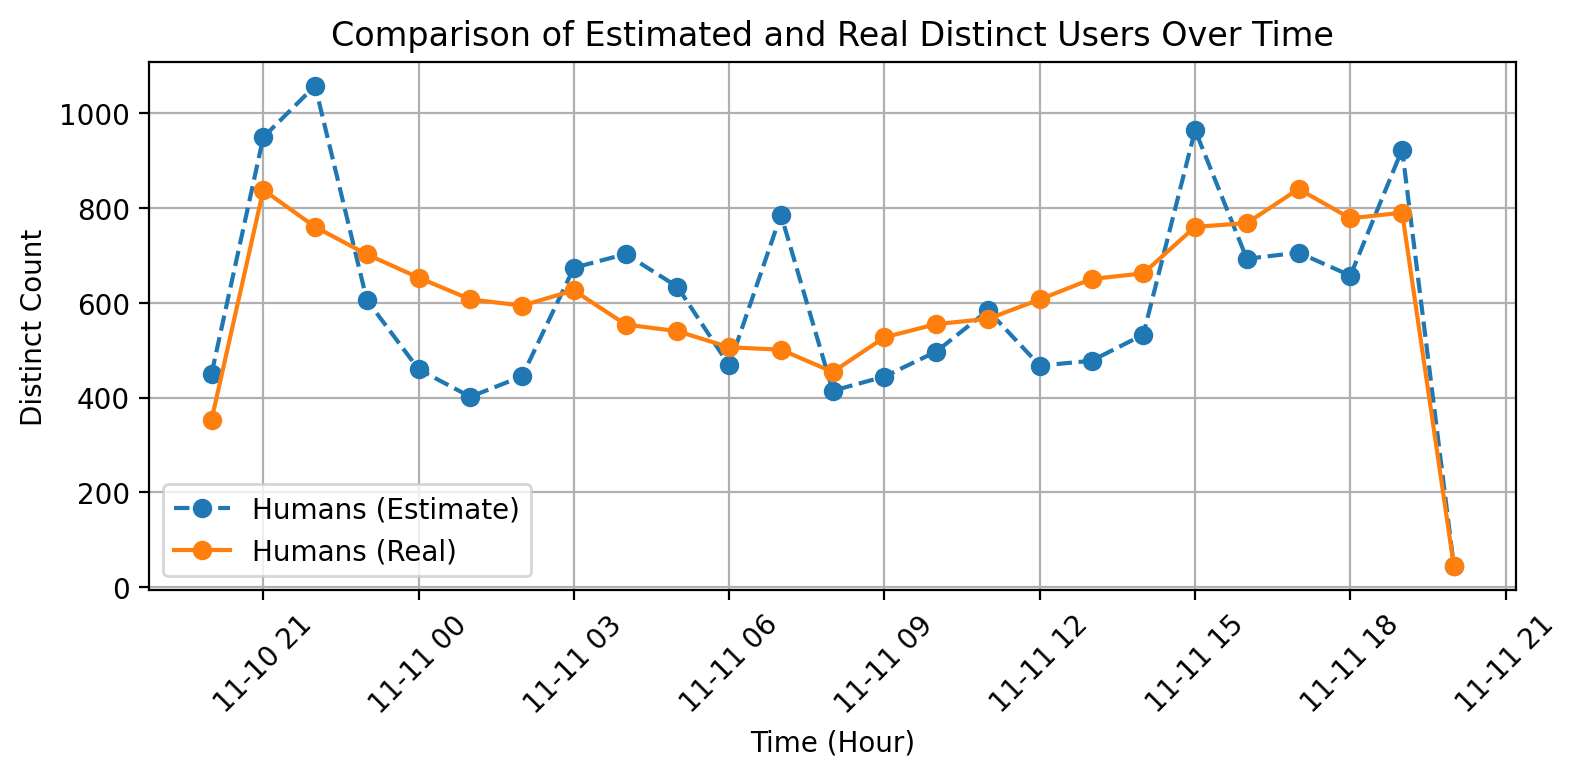

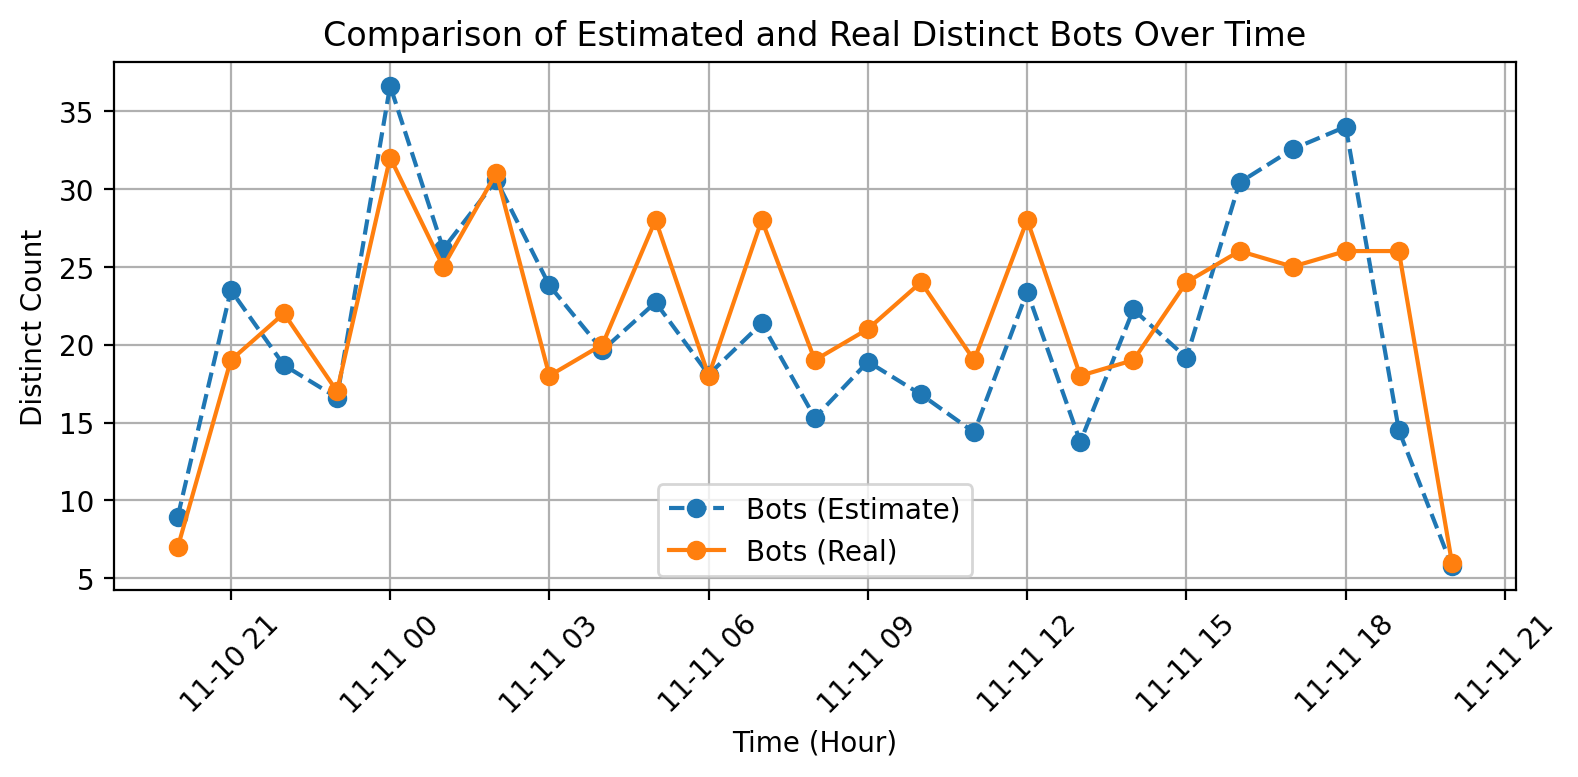

In [177]:
import matplotlib.pyplot as plt

# Convert Spark DataFrames to Pandas and prepare the data
pandas_df = final_df.toPandas()
pandas_df['hour'] = pandas_df['hour'].astype('datetime64[ns]')
pandas_df = pandas_df.sort_values(by='hour')
comparison_df = pandas_df.merge(real_counts_df.toPandas(), on="hour", suffixes=("_estimate", "_real"))

# Plot 1: Users
plt.figure(figsize=(8, 4))
plt.plot(comparison_df['hour'], comparison_df['distinct_users'], label='Humans (Estimate)', linestyle='--', marker='o')
plt.plot(comparison_df['hour'], comparison_df['real_distinct_users'], label='Humans (Real)', marker='o')

plt.xlabel('Time (Hour)')
plt.ylabel('Distinct Count')
plt.title('Comparison of Estimated and Real Distinct Users Over Time')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Bots
plt.figure(figsize=(8, 4))
plt.plot(comparison_df['hour'], comparison_df['distinct_bots'], label='Bots (Estimate)', linestyle='--', marker='o')
plt.plot(comparison_df['hour'], comparison_df['real_distinct_bots'], label='Bots (Real)', marker='o')

plt.xlabel('Time (Hour)')
plt.ylabel('Distinct Count')
plt.title('Comparison of Estimated and Real Distinct Bots Over Time')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Conclusion:**

The Flajolet-Martin algorithm is effective to get the approximation of the distribution of distinct entities. As we see on the charts we were able to get overall trend.

**Step 4**:

Comparing to approx_count_distinct which implements a boosted version of flajolet_martin algorithms HyperLogLog.

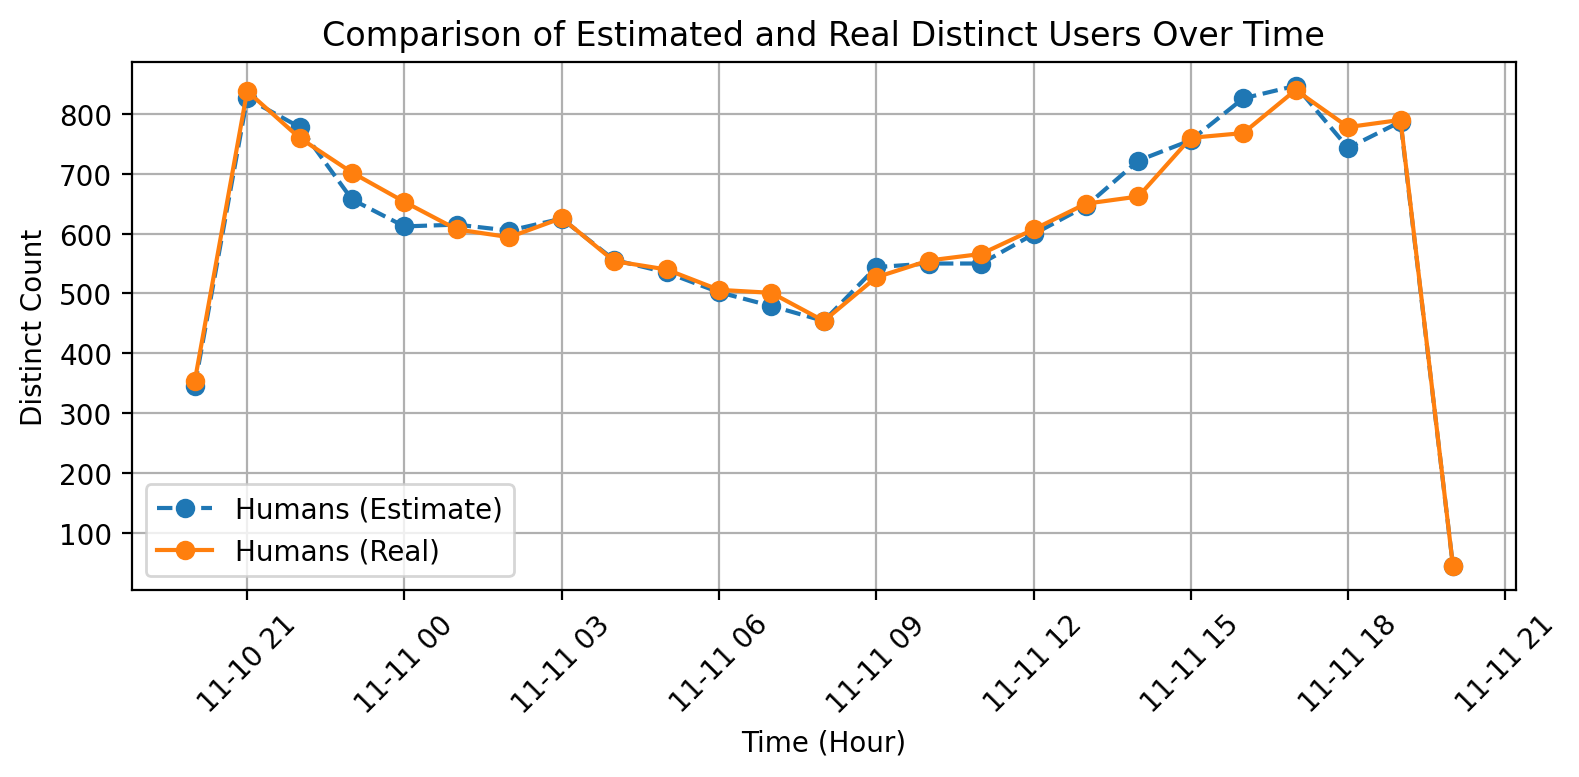

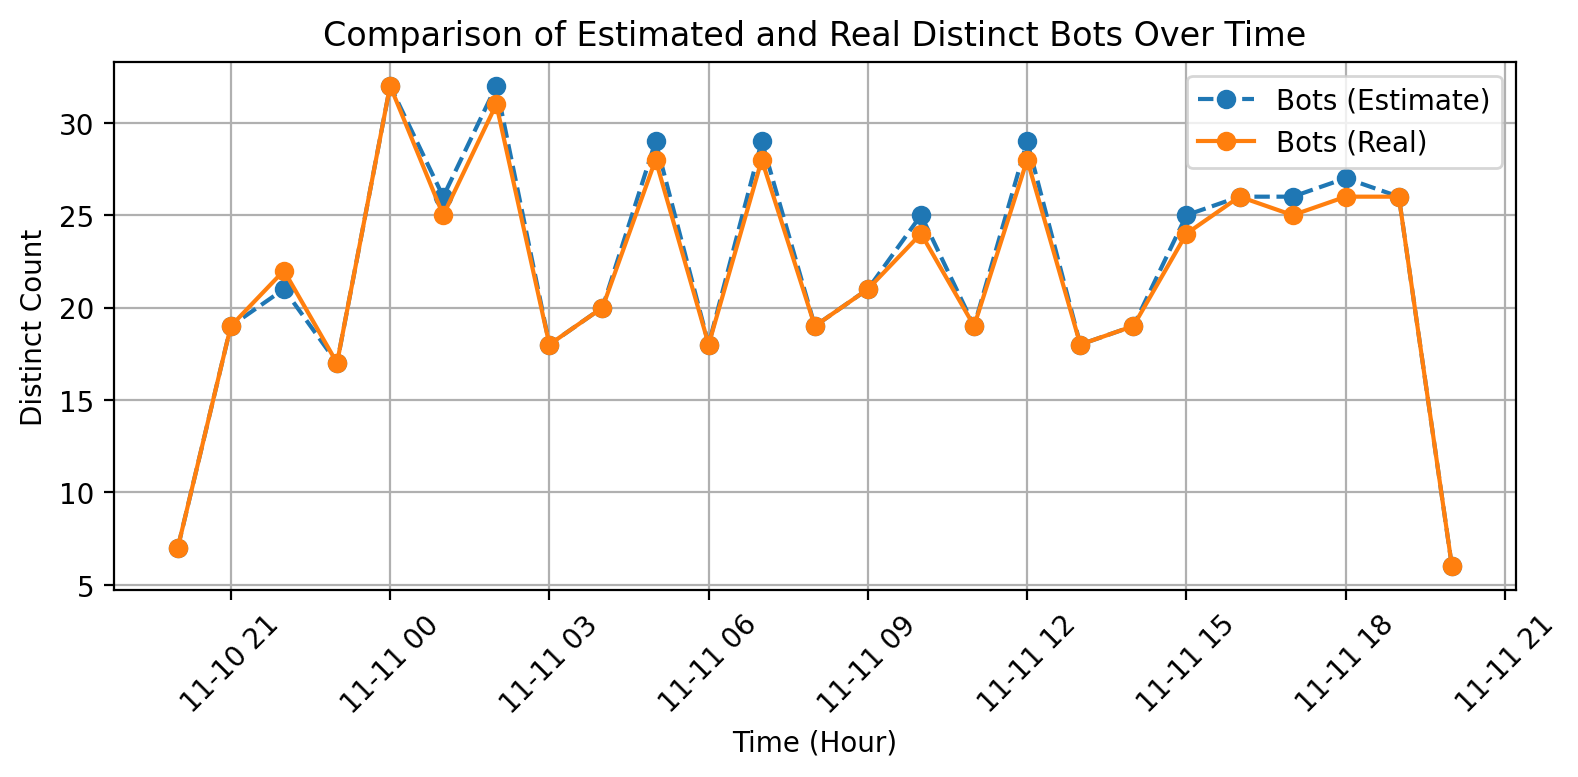

In [167]:
from pyspark.sql.functions import approx_count_distinct

spark_approx_counts = df.groupBy("hour").agg(
    approx_count_distinct(col("user")).alias("spark_approx_users"),
    approx_count_distinct(when(col("bot") == True, col("user"))).alias("spark_approx_bots")
)

spark_approx_counts_df = spark_approx_counts.toPandas()
spark_approx_counts_df['hour'] = spark_approx_counts_df['hour'].astype('datetime64[ns]')
spark_approx_counts_df = spark_approx_counts_df.sort_values(by='hour')
comparison_df = spark_approx_counts_df.merge(real_counts_df.toPandas(), on="hour", suffixes=("_estimate", "_real"))

# Plot 1: Users
plt.figure(figsize=(8, 4))
plt.plot(comparison_df['hour'], comparison_df['spark_approx_users'], label='Humans (Estimate)', linestyle='--', marker='o')
plt.plot(comparison_df['hour'], comparison_df['real_distinct_users'], label='Humans (Real)', marker='o')

plt.xlabel('Time (Hour)')
plt.ylabel('Distinct Count')
plt.title('Comparison of Estimated and Real Distinct Users Over Time')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Bots
plt.figure(figsize=(8, 4))
plt.plot(comparison_df['hour'], comparison_df['spark_approx_bots'], label='Bots (Estimate)', linestyle='--', marker='o')
plt.plot(comparison_df['hour'], comparison_df['real_distinct_bots'], label='Bots (Real)', marker='o')

plt.xlabel('Time (Hour)')
plt.ylabel('Distinct Count')
plt.title('Comparison of Estimated and Real Distinct Bots Over Time')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Summary**:

HyperLogLog is a an improvement compared to Flajolet-Martin. We can clearly see that this algorithm is much smoother and better with the aproximation.

## 2.2 Exploration of edits events

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

pd_df = df.toPandas()

In [169]:
pd_df['change'] = pd.to_numeric(pd_df['change'], errors='coerce')
pd_df["comment_len"] = pd_df["comment"].str.len()

pd_df['log_change'] = np.where(
    pd_df['change'] > 0, np.log1p(pd_df['change']),   # log(1 + x) for positive values
    -np.log1p(-pd_df['change'])                       # -log(1 + |x|) for negative values
)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


### **Histogram of "change" distribution** for bots and humans.

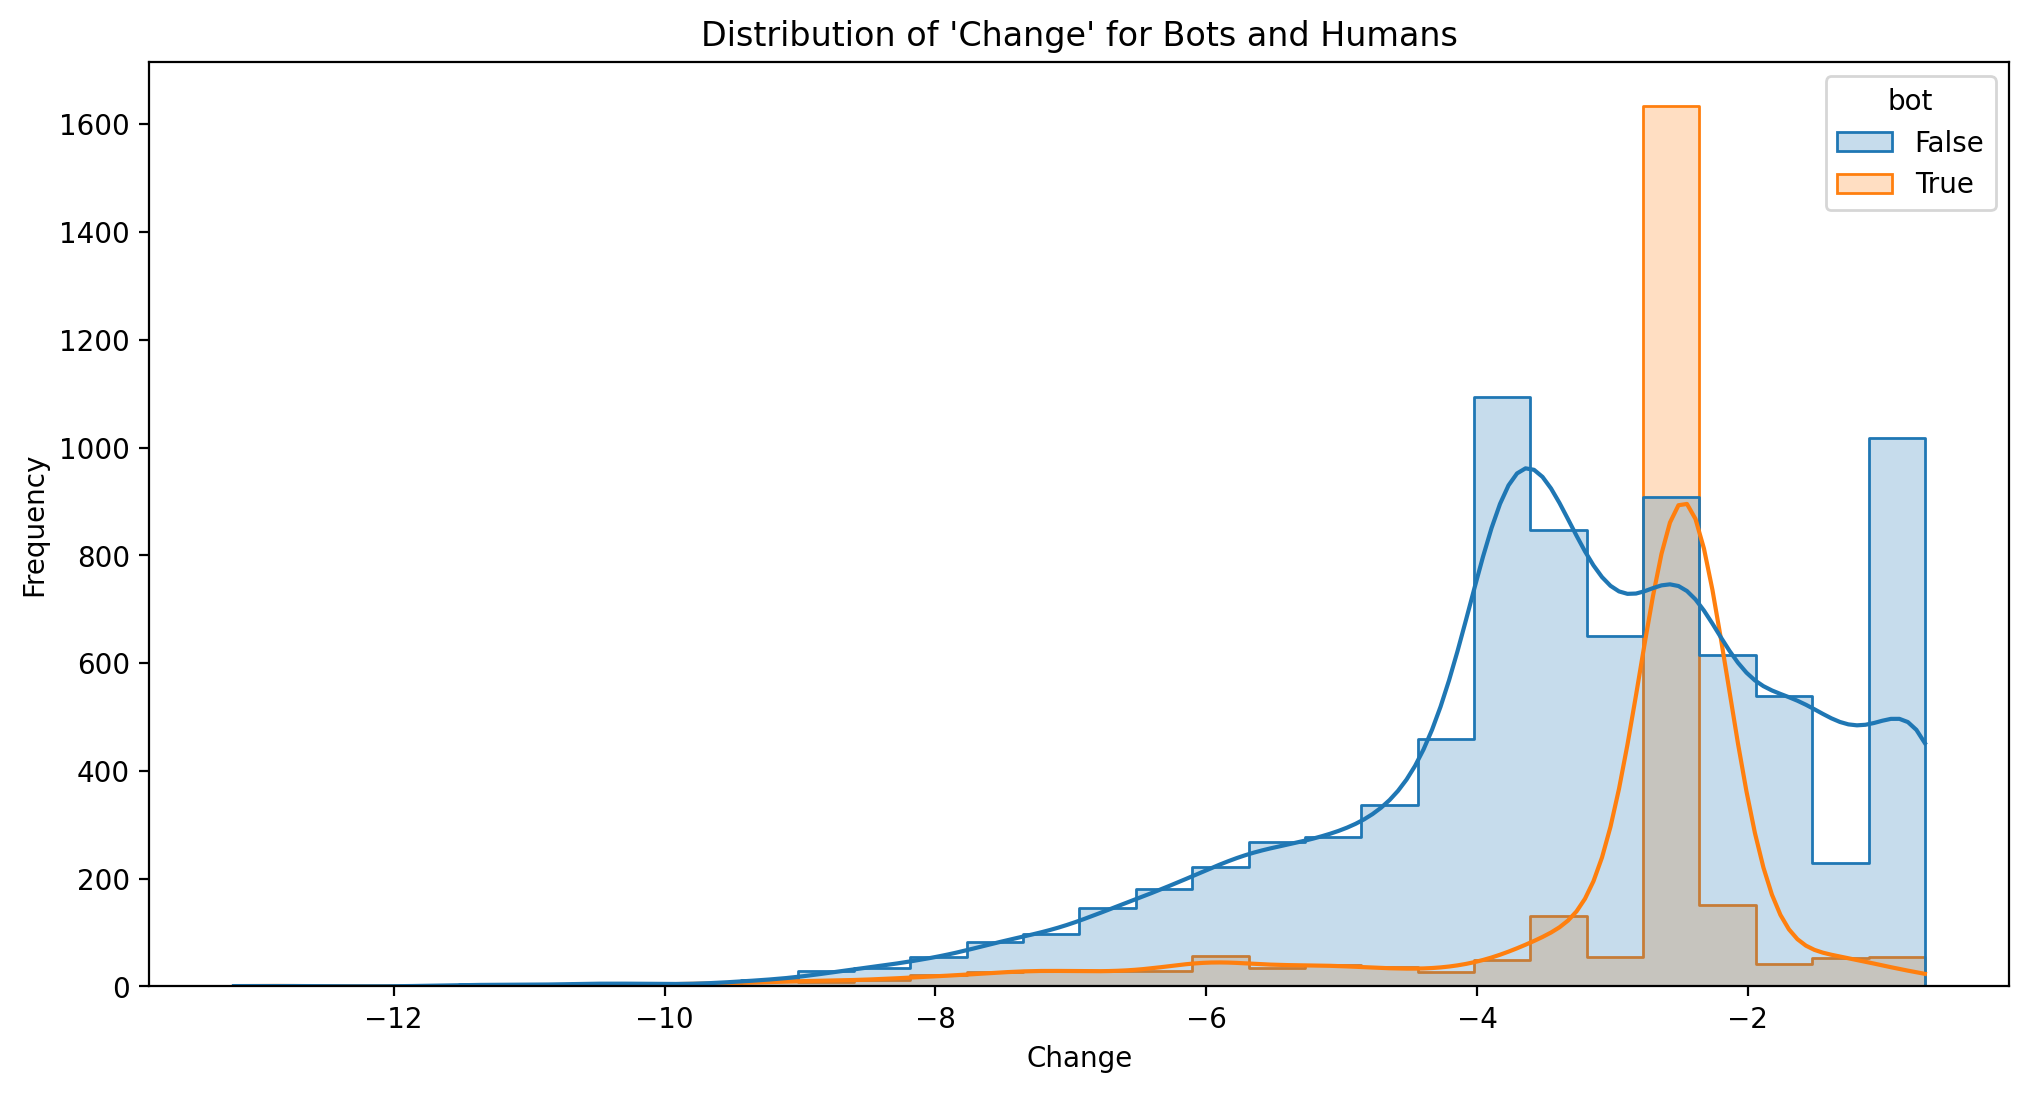

In [170]:
plt.figure(figsize=(12, 6))
sns.histplot(data=pd_df[pd_df['change'] < 0], x="log_change", hue="bot", element="step", kde=True, bins=30)
plt.title("Distribution of 'Change' for Bots and Humans")
plt.xlabel("Change")
plt.ylabel("Frequency")
plt.show()

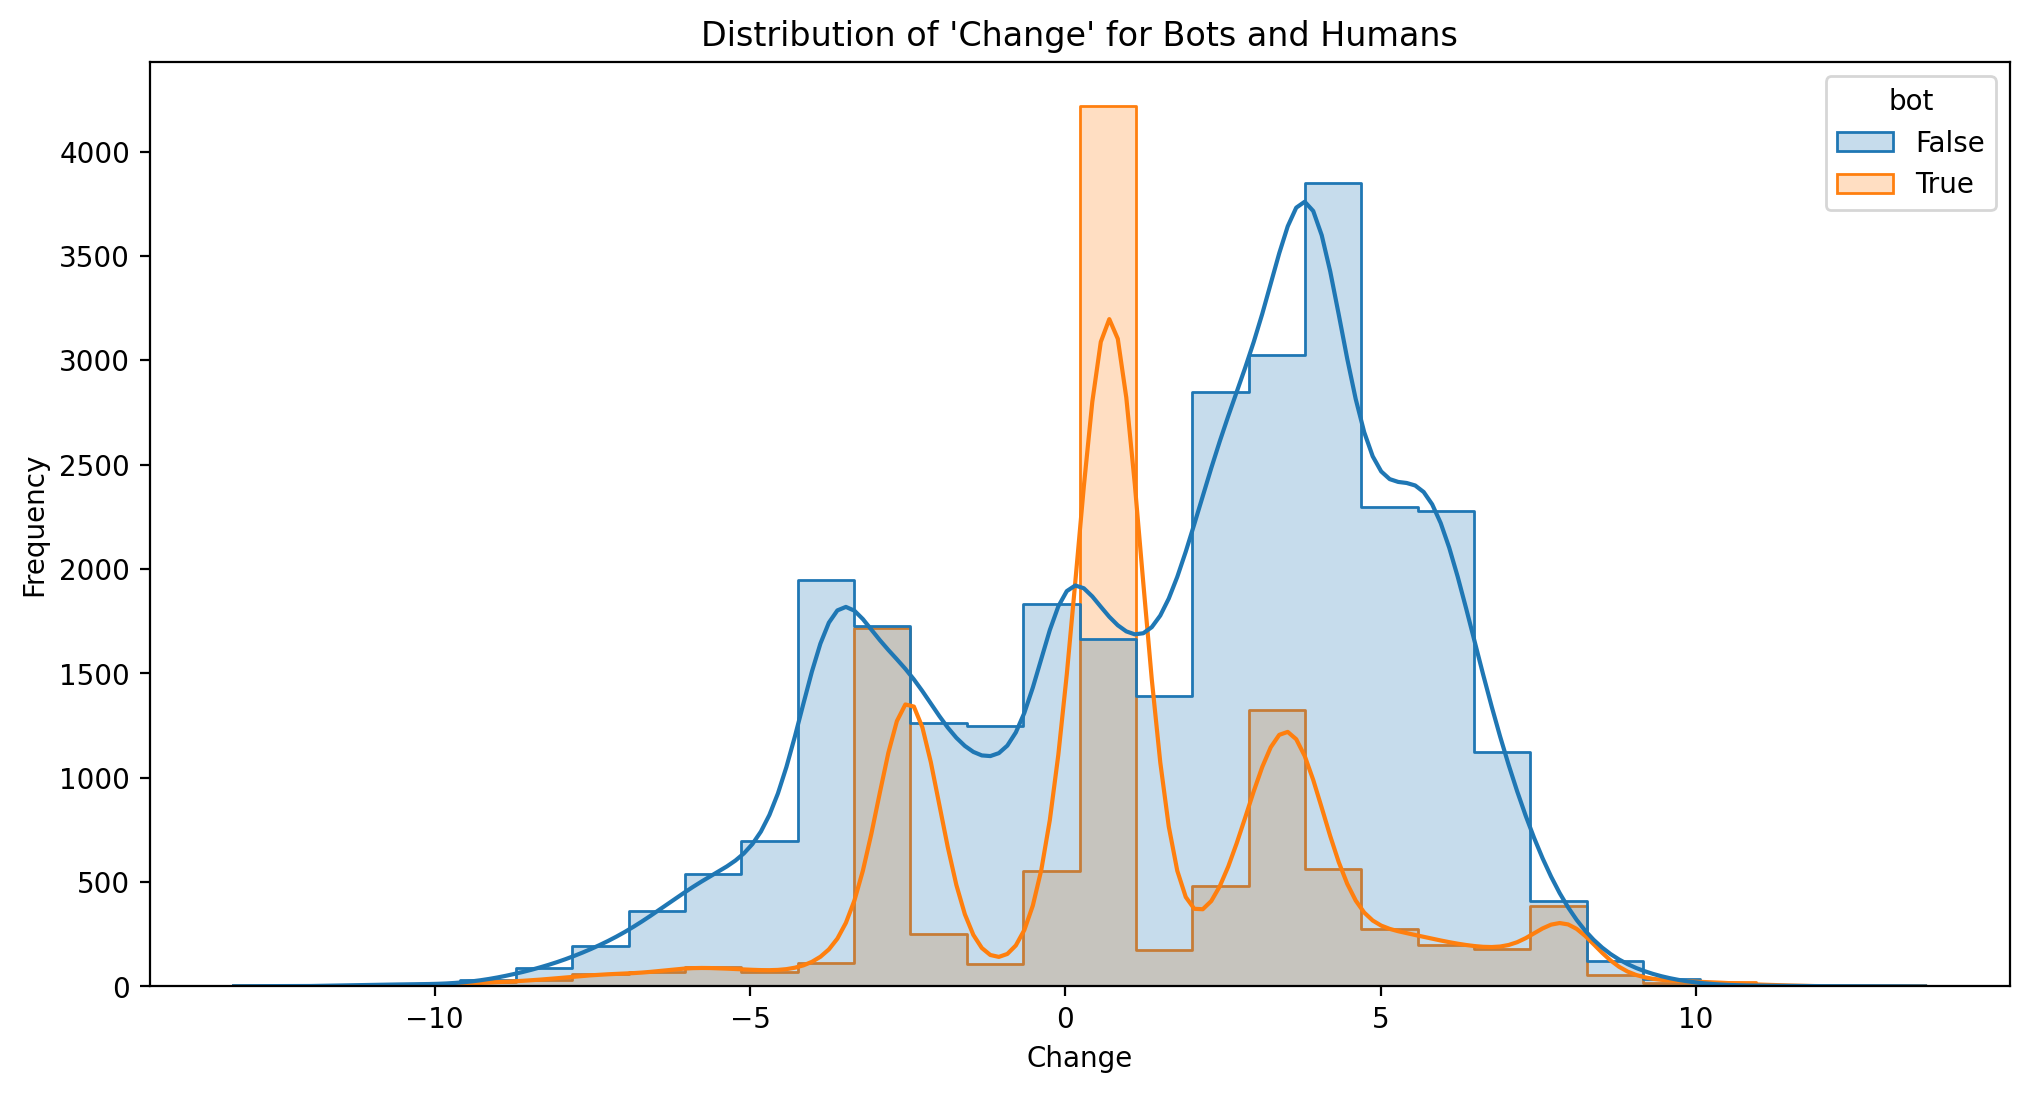

In [171]:
plt.figure(figsize=(12, 6))
sns.histplot(data=pd_df, x="log_change", hue="bot", element="step", kde=True, bins=30)
plt.title("Distribution of 'Change' for Bots and Humans")
plt.xlabel("Change")
plt.ylabel("Frequency")
plt.show()

This plot suggest that the bots perform more limited behavior (frequent change = 0), while humans usually show greater variability, which indicates that their actions are more diverse.

**Distribution** without outliers

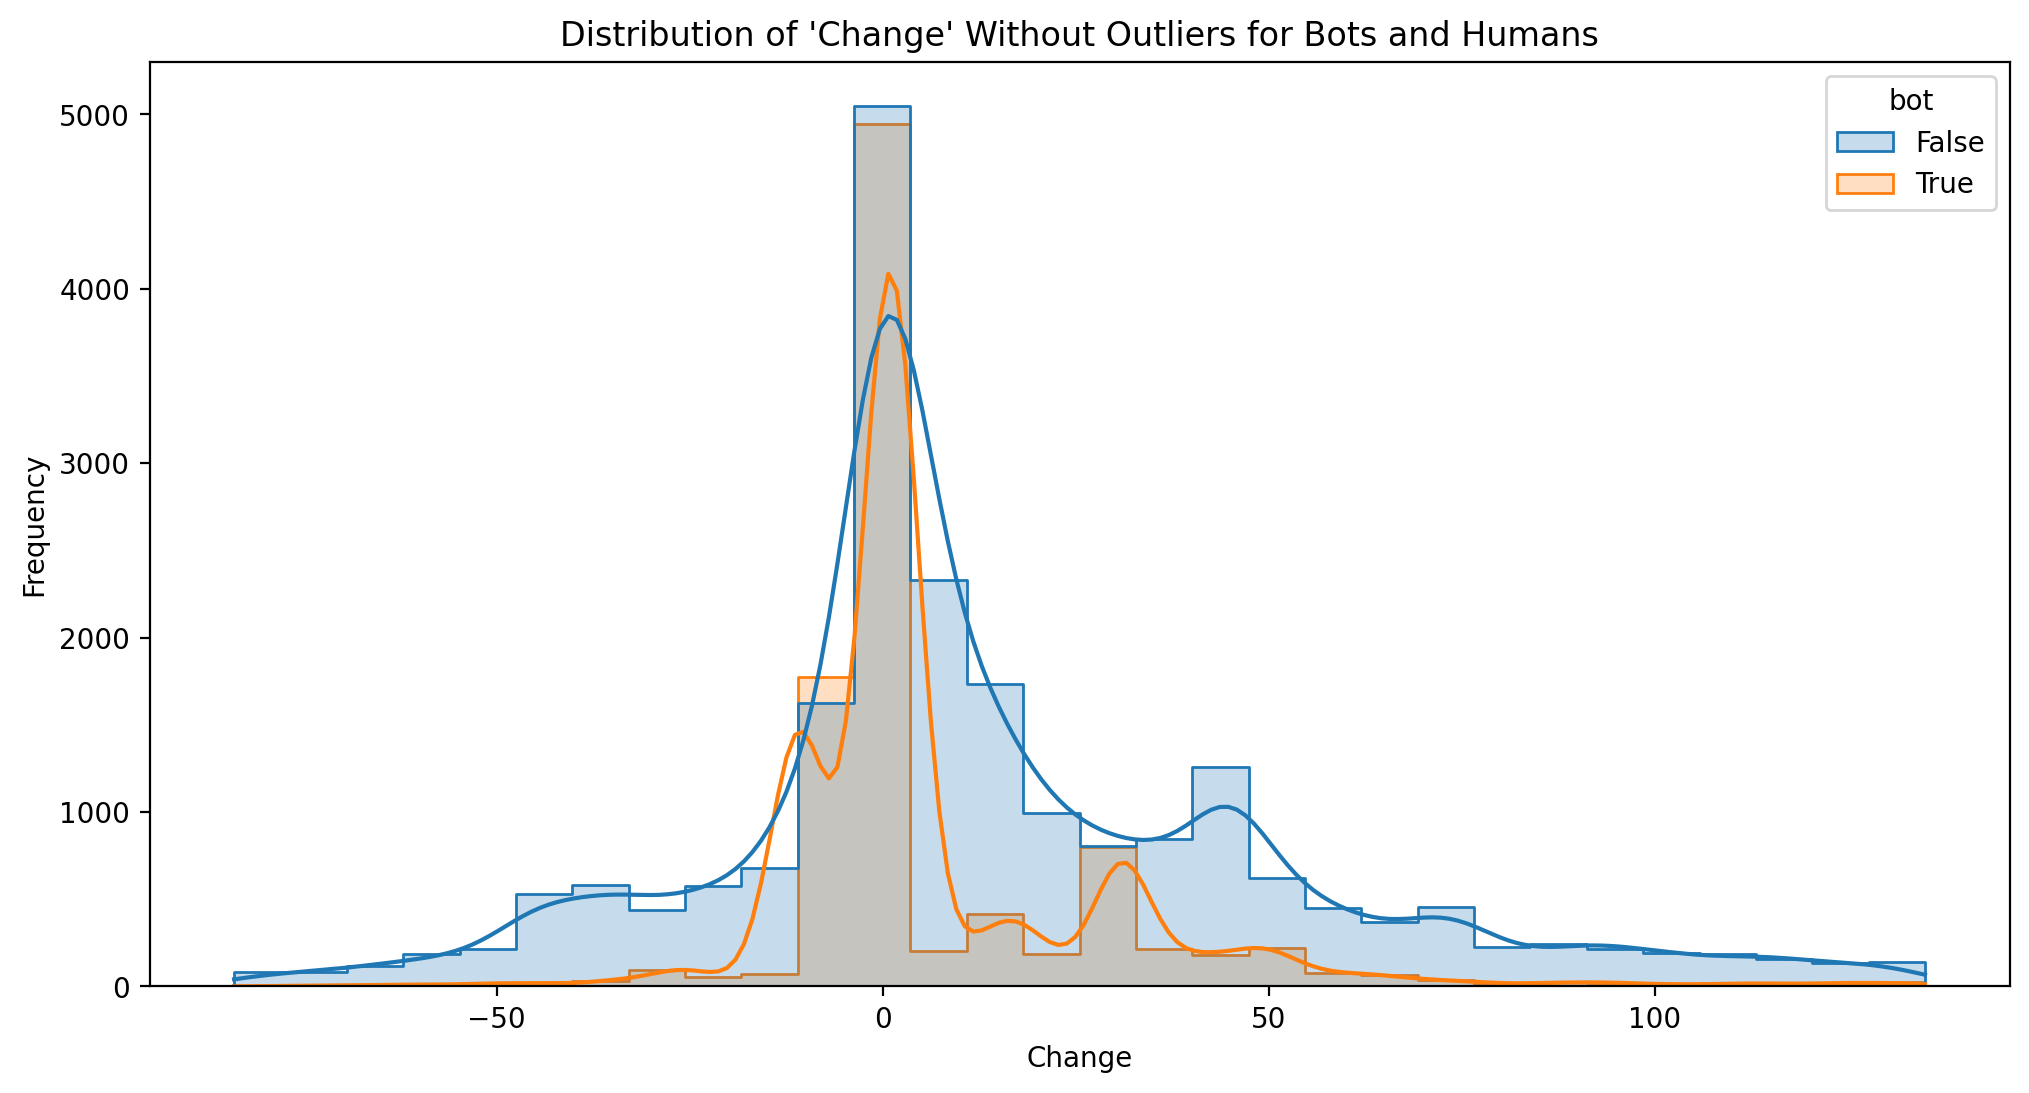

In [172]:
Q1 = pd_df['change'].quantile(0.25)
Q3 = pd_df['change'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


filtered_data_pd = pd_df[(pd_df['change'] >= lower_bound) & (pd_df['change'] <= upper_bound)]

plt.figure(figsize=(12, 6))
sns.histplot(data=filtered_data_pd, x="change", hue="bot", element="step", kde=True, bins=30)
plt.title("Distribution of 'Change' Without Outliers for Bots and Humans")
plt.xlabel("Change")
plt.ylabel("Frequency")
plt.show()

This plot shows that bots tend to perform repetitive tasks with minimal changes, at the same time humans do different actions.

In [173]:
bot_keywords = ["tagging", "updating", "moving", "update", "next queue", "added", "copying", "[[user:"]

pd2_df = pd_df.copy()
pd2_df['is_bot_comment'] = pd2_df['comment'].str.lower().apply(
    lambda x: any(x.startswith(keyword) for keyword in bot_keywords) if isinstance(x, str) else False
)

pd2_df = pd2_df[["bot", "change", 'comment_len', 'is_bot_comment']]
pd2_df['bot'] = pd2_df['bot'] == 'True'
pd2_df = pd2_df.dropna()

<ipython-input-173-e683e2041e81>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd2_df['bot'] = pd2_df['bot'] == 'True'


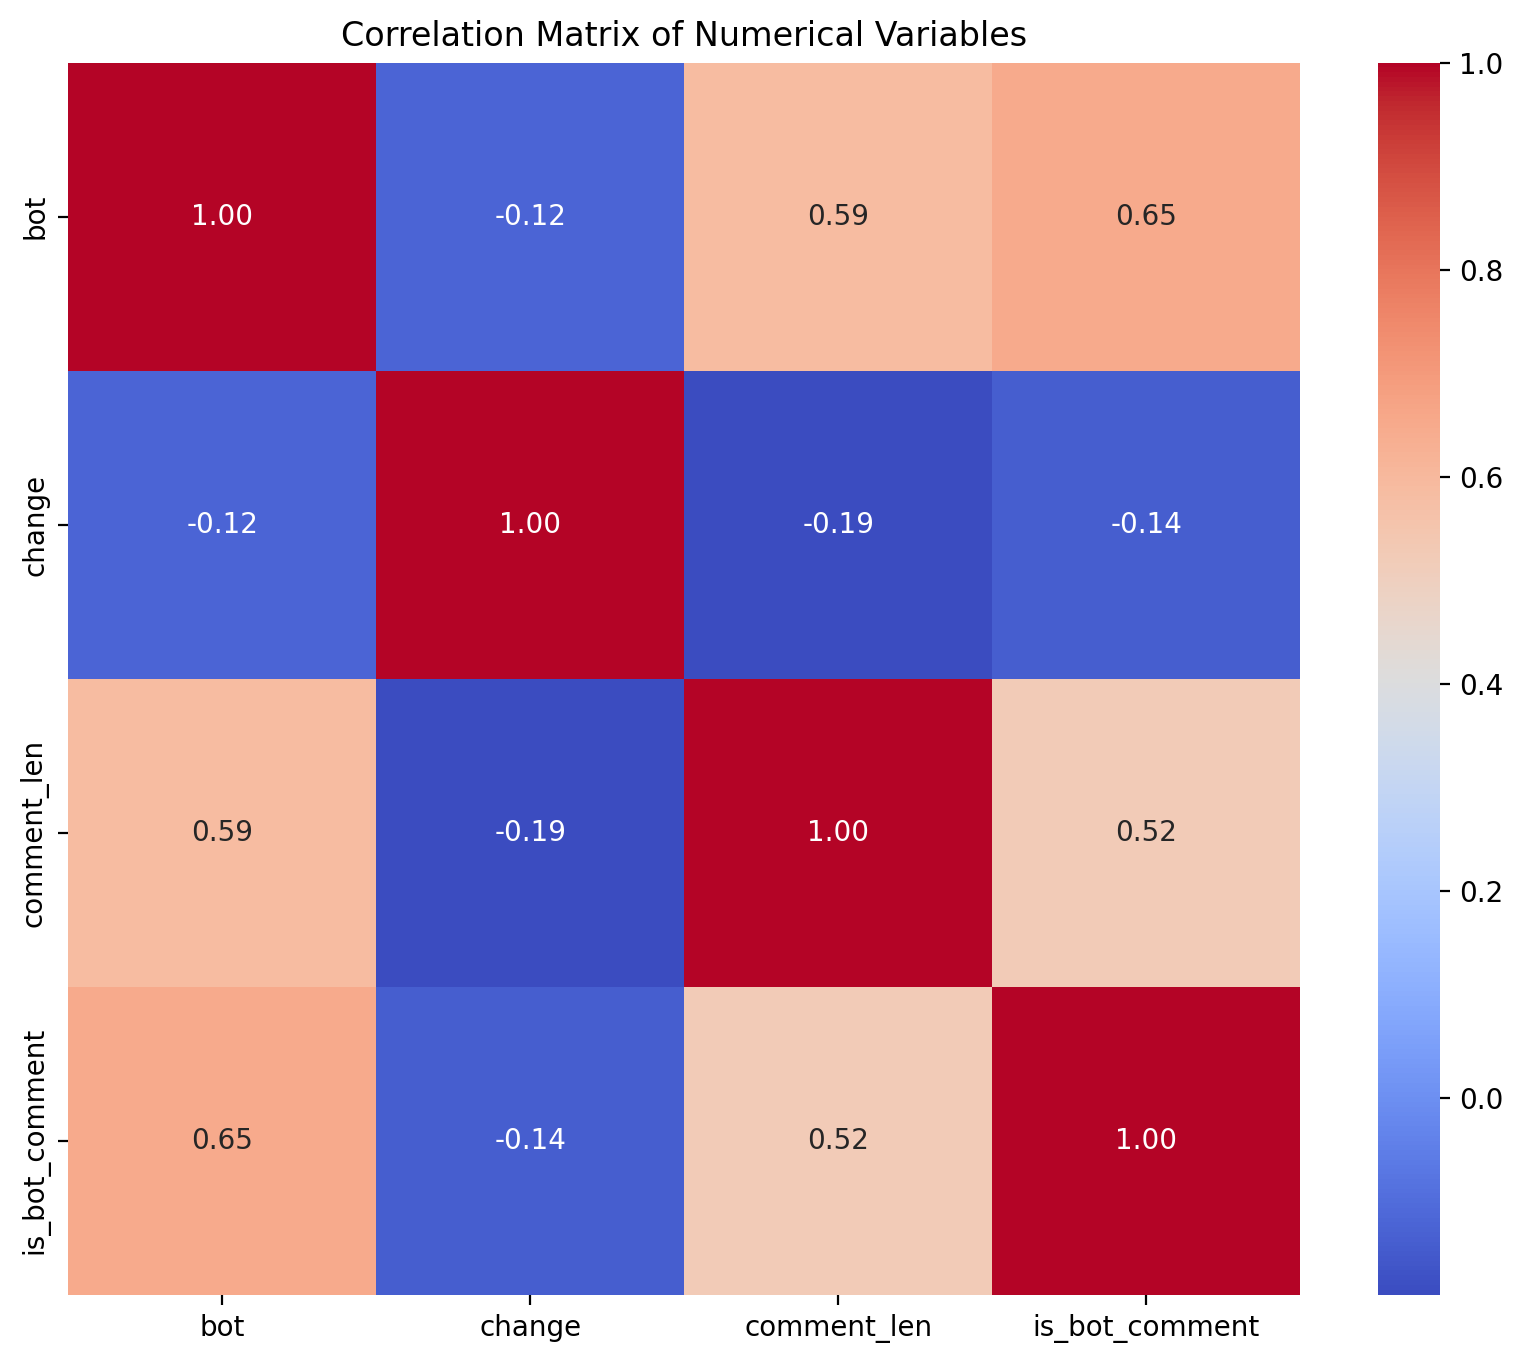

In [174]:
# Plot correlation matrix for all numerical columns
plt.figure(figsize=(10, 8))
correlation_matrix = pd2_df.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True, fmt=".2f")
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

In the heat map above we see a moderate positive correlation between bot, comment_len and is_bot_comment. The last mentioned feature is a feature that we've created by adding a simple logic based on the first words of bots' comments.

# 3. Humans/Bots Classifier

In [190]:
spark = SparkSession.builder.appName("RandomForestBotClassifier").getOrCreate()

In [193]:
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("timestamp", IntegerType(), True),
    StructField("user", StringType(), True),
    StructField("bot", BooleanType(), True),
    StructField("minor", BooleanType(), True),
    StructField("change", IntegerType(), True),
    StructField("comment", StringType(), True)
])

In [129]:
data = spark.read.csv("../data/training_data", schema=schema, header=True)
data = (
    data
    .withColumn("comment", F.coalesce(F.col("comment"), F.lit("")))
    .withColumn("bot", F.col('bot').cast("double"))
    .withColumn("minor", F.col('minor').cast("double"))
    .withColumn("comment_length", F.length("comment").cast("double"))
    .fillna({
        "minor": 0,
        "change": 0,
        "comment_length": 0
    })
    .drop("id", "title", "timestamp")
    .na.drop(subset=["bot"])
)

In [130]:
tokenizer = Tokenizer(inputCol="comment", outputCol="tokens")
hashingTF = HashingTF(inputCol="tokens", outputCol="tf_features", numFeatures=100)
idf = IDF(inputCol="tf_features", outputCol="text_features")

assembler = VectorAssembler(
    inputCols=["minor", "change", "comment_length"],
    outputCol="numeric_features",
    handleInvalid="skip"  # Skip invalid rows
)
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features", withMean=True, withStd=True)

final_assembler = VectorAssembler(inputCols=["scaled_numeric_features", "text_features"], outputCol="features")

rf = RandomForestClassifier(
    labelCol="bot",
    featuresCol="features",
    numTrees=20,
    maxDepth=5
)

pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, assembler, scaler, final_assembler, rf])

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 50]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

evaluator = MulticlassClassificationEvaluator(
    labelCol="bot", predictionCol="prediction", metricName="f1"
)

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
cvModel = crossval.fit(train_data)

In [131]:
best_model = cvModel.bestModel

In [132]:
predictions = best_model.transform(test_data)

In [133]:
recall = MulticlassClassificationEvaluator(
    labelCol="bot", predictionCol="prediction", metricName="weightedRecall"
).evaluate(predictions)

precision = MulticlassClassificationEvaluator(
    labelCol="bot", predictionCol="prediction", metricName="weightedPrecision"
).evaluate(predictions)

f1 = evaluator.evaluate(predictions)

print(f"Bot Prediction Recall: {recall:.2f}")
print(f"Bot Prediction Precision: {precision:.2f}")
print(f"Bot Prediction F1-score: {f1:.2f}")

predictions.groupBy("bot", "prediction").count().show()

Bot Prediction Recall: 0.99
Bot Prediction Precision: 0.99
Bot Prediction F1-score: 0.99
+---+----------+-----+
|bot|prediction|count|
+---+----------+-----+
|1.0|       1.0| 2081|
|1.0|       0.0|  102|
|0.0|       0.0| 5697|
|0.0|       1.0|    4|
+---+----------+-----+



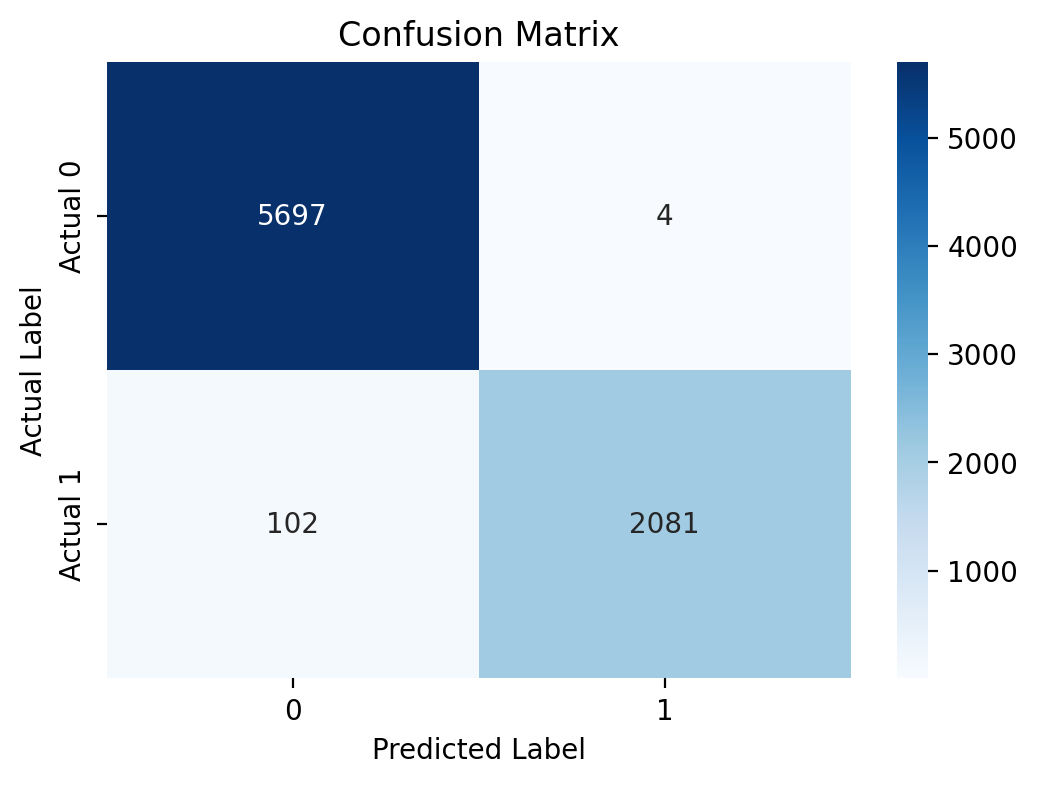

In [134]:
confusion_matrix_pivot = (
    predictions
    .groupBy("bot", "prediction")
    .count()
    .groupBy("bot")
    .pivot("prediction", [0, 1])
    .sum("count")
    .fillna(0)
)

# Convert to Pandas and format
confusion_matrix_pandas = confusion_matrix_pivot.toPandas().set_index("bot")
confusion_matrix_pandas.rename(columns={0: "Predicted 0", 1: "Predicted 1"}, index={0: "Actual 0", 1: "Actual 1"},
                               inplace=True)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_pandas, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


Showing recognized and unrecognized bot users:

In [135]:
(
    predictions
    .select("user", "bot", "prediction")
    .select(F.countDistinct("user").alias("distinct_users"),
            F.countDistinct(F.when(F.col("bot") == 1.0, F.col("user"))).alias("distinct_real_bots"),
            F.countDistinct(F.when(F.col("prediction") == 1.0, F.col("user"))).alias("distinct_predicted_bots")
    )
).show()

+--------------+------------------+-----------------------+
|distinct_users|distinct_real_bots|distinct_predicted_bots|
+--------------+------------------+-----------------------+
|          3125|                61|                     42|
+--------------+------------------+-----------------------+



In [136]:
# Collect distinct bot users and recognized bot users
bot_users = predictions.filter(F.col("bot") == 1.0).select("user").distinct()
recognized_bot_users = predictions.filter((F.col("bot") == 1.0) & (F.col("prediction") == 1.0)).select("user").distinct()

# Identify unrecognized bots directly
unrecognized_bots = (
    bot_users
    .subtract(recognized_bot_users)
    .withColumn("is_recognized", F.lit(False))
)

# Aggregate and update the recognition status
(
    predictions
    .filter(F.col("bot") == 1.0)
    .join(unrecognized_bots, "user", "left")
    .withColumn("is_recognized", F.when(F.col("is_recognized").isNull(), F.lit(True)).otherwise(F.col("is_recognized")))
    .groupBy("user", "is_recognized")
    .count()
    .orderBy(F.col("is_recognized").desc(), F.col("count").desc())
    .withColumnRenamed("count", "amount_of_records")
).show(100)

+--------------------+-------------+-----------------+
|                user|is_recognized|amount_of_records|
+--------------------+-------------+-----------------+
|             Monkbot|         true|              859|
|              Cewbot|         true|              536|
|          GreenC bot|         true|              145|
|          WP 1.0 bot|         true|              115|
|               OAbot|         true|               65|
|MediaWiki message...|         true|               63|
|            PrimeBOT|         true|               40|
|        Citation bot|         true|               35|
|           AnomieBOT|         true|               27|
|           SDZeroBot|         true|               26|
|Lowercase sigmabo...|         true|               24|
|            EmausBot|         true|               22|
|      JJMC89 bot III|         true|               19|
|         ClueBot III|         true|               19|
|        InceptionBot|         true|               16|
|         

# 4. Finalized Bots user names list based on the Classifier

Reading another set of an unknown (for the model) data to evaluate the performance.

In [196]:
unlabeled_data = spark.read.csv("../data/unlabeled_data", schema=schema, header=True)
unlabeled_data = (
    unlabeled_data
    .withColumn("comment", F.coalesce(F.col("comment"), F.lit("")))
    .withColumn("bot", F.col('bot').cast("double"))
    .withColumn("minor", F.col('minor').cast("double"))
    .withColumn("comment_length", F.length("comment").cast("double"))
    .fillna({
        "minor": 0,
        "change": 0,
        "comment_length": 0
    })
    .drop("id", "title", "timestamp")
    .na.drop(subset=["bot"])
)

In [197]:
predictions_df = cvModel.transform(data.unionByName(unlabeled_data, allowMissingColumns=True))

In [198]:
distinct_bots_df = (
    predictions_df
      .where(F.col("prediction") == 1.0)
      .select("user", "bot")
      .distinct()
)

distinct_bots = [row.user for row in distinct_bots_df.collect()]

In [199]:
distinct_bots

['DatBot',
 'Cewbot',
 'Pi bot',
 'B-bot',
 'DPL bot',
 'Legobot',
 'RMCD bot',
 'ClueBot III',
 'ListeriaBot',
 'WugBot',
 'RussBot',
 'FastilyBot',
 'Citation bot',
 'GreenC bot',
 'Bot1058',
 'Yapperbot',
 'Community Tech bot',
 'FireflyBot',
 'JJMC89 bot III',
 'JJMC89 bot',
 'MusikBot II',
 'BattyBot',
 'FMSky',
 'Lowercase sigmabot III',
 'AAlertBot',
 'WP 1.0 bot',
 'EarwigBot',
 'Filedelinkerbot',
 'InternetArchiveBot',
 'HaleBot',
 'HotArticlesBot',
 'SDZeroBot',
 'Cyberbot I',
 'AnomieBOT',
 'Qwerfjkl (bot)',
 'Monkbot',
 'EmausBot',
 'DeltaQuadBot',
 'Aidan9382-Bot',
 'HBC AIV helperbot14',
 'OAbot',
 'Mathbot',
 'TNTBot',
 'DYKUpdateBot',
 'IvanScrooge98',
 'Xexerss',
 'Mason7512',
 'MediaWiki message delivery',
 'ChristieBot',
 'AManWithNoPlan',
 'AnomieBOT II',
 'Aviator Jr',
 'Knitsey',
 'MilHistBot',
 'PrimeBOT',
 'Sloopyploop',
 'InceptionBot',
 'Abductive',
 'Free ori',
 'PinkDucky91',
 'Plasticwonder',
 'Toweli']

# 5. Bloom Filter

For a given **Bloom Filter** we consider the next properties.

*False Negative* - are not possible (if we are talking about the same sample set, meaning that new items were not introduced or when introduces are added to the BF)

*False Positive* - are possible.

BloomFilter never forgets (we cannot remove item from it).

Bit array stores results of hash functions. Result of hash function corresponds to bit array index.

K-number of hash functions defines how frequent collisions may be possible.

Seach in Bloom filter will be O(k).

In order to create a BF we need to estimate its capacity by assuming how many elements we will fit in it.


**Why MurmurHash**:

Its support seeds parameter which enables efficient generation of multiple independent hash functions, which is essential for Bloom Filter operation.

We need multiple hash functions to minimize collisions(hash count parameter). Instead of creating separate hash functions, we use the same hashing algorithm (mmh3.hash()) with different seeds - this basically simulates using many hash functions.

In [142]:
class BloomFilter:
    def __init__(self, size, hash_count):
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.size = size
        self.hash_count = hash_count

    def add(self, item):
        for i in range(self.hash_count):
            index = mmh3.hash(str(item), i) % self.size
            self.bit_array[index] = 1

    def __contains__(self, item):
        for i in range(self.hash_count):
            index = mmh3.hash(str(item), i) % self.size
            if self.bit_array[index] == 0:
                return False
        return True


BloomFilter Training is done by adding elements to it.

Size should be selected according to the requirement of 10% error.

In [200]:
import math

def calculate_params(n, p):
    """
      n (int): Number of elements to insert into the Bloom Filter.
      p (float): Desired false-positive rate.

      m (int): Size of the Bloom Filter (number of bits).
      k (int): Number of hash functions.
    """
    m = math.ceil(-(n * math.log(p)) / (math.log(2) ** 2))
    k = math.ceil((m / n) * math.log(2))

    return m, k

n = len(distinct_bots)
p = 0.1 # desirable fpr
m, k = calculate_params(n, p)

print(f"Optimal size of Bloom Filter (m): {m} bits")
print(f"Optimal number of hash functions (k): {k}")

Optimal size of Bloom Filter (m): 298 bits
Optimal number of hash functions (k): 4


**Train** stage of **Bloom Filter** is when we add elements to it.

In [201]:
from pyspark.sql.functions import col
from pyspark.sql import Row
import pickle

bloom = BloomFilter(size=m, hash_count=k)

bot_names = distinct_bots

for bot_name in bot_names:
    bloom.add(bot_name)

print(f"Bloom Filter contains {len(bot_names)} bots.")

# bloom_state = pickle.dumps((bloom.bit_array, bloom.hash_count, bloom.size))
with open("../artifacts/bloom_state.pkl", "wb") as file:
    pickle.dump((bloom.bit_array, bloom.hash_count, bloom.size), file)

Bloom Filter contains 62 bots.


*Usage example:*

In [202]:
from pyspark.sql.functions import udf

with open("../artifacts/bloom_state.pkl", "rb") as file:
    deserialized_data = pickle.load(file)

serialized_data = pickle.dumps(deserialized_data)
broadcast_bloom_filter = spark.sparkContext.broadcast(serialized_data)

def check_bloom_filter(item):
    bit_array, hash_count, size = pickle.loads(broadcast_bloom_filter.value)
    for i in range(hash_count):
        index = mmh3.hash(str(item), i) % size
        if bit_array[index] == 0:
            return False
    return True


bloom_udf = udf(check_bloom_filter, BooleanType())
result_df = unlabeled_data.withColumn("is_bot_bloom", bloom_udf(col("user")))

In [203]:
result_df = result_df.withColumn(
    "error_type",
    F.when((F.col("is_bot_bloom") == True) & (F.col("bot") == False), "FP")
    .when((F.col("is_bot_bloom") == False) & (F.col("bot") == True), "FN")
    .when((F.col("is_bot_bloom") == True) & (F.col("bot") == True), "TP")
    .when((F.col("is_bot_bloom") == False) & (F.col("bot") == False), "TN")
)

error_counts = result_df.groupBy("error_type").count()

counts = error_counts.collect()
counts_dict = {row["error_type"]: row["count"] for row in counts}

TP = counts_dict.get("TP", 0)
FP = counts_dict.get("FP", 0)
FN = counts_dict.get("FN", 0)
TN = counts_dict.get("TN", 0)

fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
fnr = FN / (FN + TP) if (FN + TP) > 0 else 0

print(f"False Positive Rate (FPR): {fpr}")
print(f"False Negative Rate (FNR): {fnr}")

False Positive Rate (FPR): 0.0943013698630137
False Negative Rate (FNR): 0.06342857142857143


As we can see, the FPR is about 10% while FNR is much bigger but this comes from the perfomance of the classifier model and the fact that new bots can appear in the stream with time. We wish to use Bloom Filter in a real stream now in order to see how it performs in 'production'.